In [2]:
import numpy as np
import torchvision
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.datasets as dset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple neural network model
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            nn.Linear(500, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
# Load MNIST train, val, and test data
trans = transforms.Compose([transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))]) # normalize transform
mnist = dset.MNIST(root='/content/drive/MyDrive', train=True, download=True, transform=trans)
test = dset.MNIST(root='/content/drive/MyDrive', train=False, download=True, transform=trans)
#train, val = random_split(mnist, [50000, 10000])
#val_loader = torch.utils.data.DataLoader(val, batch_size=len(val), shuffle=False)


In [21]:
# Load data and set batch size
batch_size = 32
train_loader = torch.utils.data.DataLoader(mnist, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

# Instantiate the model
model = Net().to(device)
#print(model)

# Train model
loss_train = train_model(model, train_loader, lr=0.01, epochs=20, optimizer=0)
test_model(model, test_loader)

Epoch [1/20], Loss: 0.3337695002555847
Epoch [2/20], Loss: 0.24771486222743988
Epoch [3/20], Loss: 0.1922551691532135
Epoch [4/20], Loss: 0.07246838510036469
Epoch [5/20], Loss: 0.08376633375883102
Epoch [6/20], Loss: 0.22390013933181763
Epoch [7/20], Loss: 0.03679385408759117
Epoch [8/20], Loss: 0.08285542577505112
Epoch [9/20], Loss: 0.01561457198113203
Epoch [10/20], Loss: 0.0593804195523262
Epoch [11/20], Loss: 0.09138298034667969
Epoch [12/20], Loss: 0.019503168761730194
Epoch [13/20], Loss: 0.07253731042146683
Epoch [14/20], Loss: 0.030977245420217514
Epoch [15/20], Loss: 0.03019643947482109
Epoch [16/20], Loss: 0.0027266161050647497
Epoch [17/20], Loss: 0.013621581718325615
Epoch [18/20], Loss: 0.01007771585136652
Epoch [19/20], Loss: 0.01768166944384575
Epoch [20/20], Loss: 0.017162995412945747
training time: 302.116423368454
Accuracy on the test set: 97.93%


In [18]:
def train_model(model, train_loader, lr=0.001, epochs=30, optimizer=0, scheduler=False):
  # Define loss function
  criterion = nn.CrossEntropyLoss()

  # Training the model
  loss_train_arr=np.zeros(epochs)
  #batch_size = 64
  if (optimizer==0): #SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  elif (optimizer==1): #Adam
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  elif (optimizer==2): #Adagrad
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)
  else: #RMSProp
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

  # Scheduler for learning rate decay (barebones line-search)
  if (scheduler): scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

  start_time = time.time()
  for i in range(epochs):
    loss_train=0
    model.train()
    for batch, (images, labels) in enumerate(train_loader):

      # Move to GPU
      images = images.to(device)
      labels = labels.to(device)

      # Zero gradient
      optimizer.zero_grad()

      # Forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # Backward pass
      loss.backward()

      # Update weights
      optimizer.step()


    if (scheduler): scheduler.step()
    print(f"Epoch [{i+1}/"+str(epochs)+f"], Loss: {loss.item()}")
    loss_train_arr[i] = loss.item()

  training_time = time.time() - start_time
  print('training time: ' + str(training_time))

  return loss_train_arr


In [8]:
def test_model(model, test_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print(f"Accuracy on the test set: {(100 * correct / total):.2f}%")

In [101]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy on the train set: {(100 * correct / total):.2f}%")

Accuracy on the train set: 9.31%


Text(0.5, 0, 'Epoch')

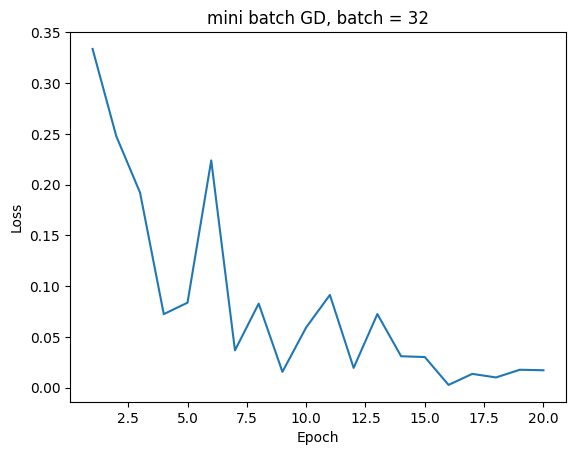

In [22]:
epoch = np.arange(20)+1


plt.plot(epoch, loss_train)
plt.title("mini batch GD, batch = 32")
plt.ylabel("Loss")
plt.xlabel("Epoch")
